## Problem Statement 

To build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Pipelines that will be performed:

We need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json, numpy as np, pandas as pd
import re, nltk, spacy, string

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json") # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
pd.set_option('display.max_columns', 25)

df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
df.shape

(78313, 22)

In [8]:
#Assign new column names
df.rename(columns = {
    '_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code', '_source.complaint_id':'complaint_id', '_source.issue':'issue', 
    '_source.date_received':'date_received', '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product', '_source.company_response':'company_response',
    '_source.company':'company', '_source.submitted_via':'submitted_via', '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
    '_source.sub_product':'sub_product', '_source.timely':'timely', '_source.complaint_what_happened':'complaint_what_happened', '_source.sub_issue':'sub_issue', 
    '_source.consumer_consent_provided':'consumer_consent_provided'
}, 
inplace = True)

df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace("", np.nan)

In [10]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].isna() ==False]

In [11]:
df = df.reset_index().drop('level_0', axis=1)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower()
    text = re.sub('\[.*\]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\S*\d\S*\s', '', text)
    text = re.sub('\s{2,}',' ',text)
    text = text.strip()
    
    return text

df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: clean_data(x))
df['complaint_what_happened'][0]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help'

In [13]:
#Write your function to Lemmatize the texts
def lemmatize(text):
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if not token.is_stop]
    sent = ' '.join(filtered_words)
    
    return sent

df['complaint_what_happened_lemmatized'] = df['complaint_what_happened'].apply(lambda x: lemmatize(x))
df['complaint_what_happened_lemmatized'][0]

'good morning xxxx xxxx appreciate help stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help'

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened', 'complaint_what_happened_lemmatized']]

In [15]:
df_clean.head(5)

,complaint_what_happened,complaint_what_happened_lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
1,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
2,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
3,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [16]:
#Write your function to extract the POS tags 

def pos_tag(text):
    # write your code here
    doc = nlp(text)
    NN_words = [token.text for token in doc if token.tag_ == 'NN']
    sent = ' '.join(NN_words)
    
    return sent


df_clean["complaint_POS_removed"] = df_clean['complaint_what_happened_lemmatized'].apply(lambda x: pos_tag(x)) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(5)

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...
1,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...
2,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
3,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




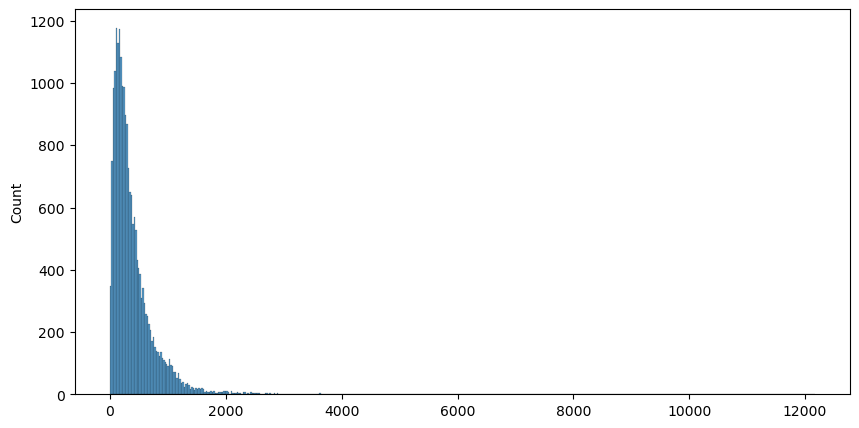

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len_dict = {i:len(df_clean['complaint_POS_removed'][i]) for i in range(df_clean.shape[0])}

plt.figure(figsize=(10,5))
sns.histplot(complaint_len_dict);

#### Find the top 40 words by frequency among all the articles after processing the text.

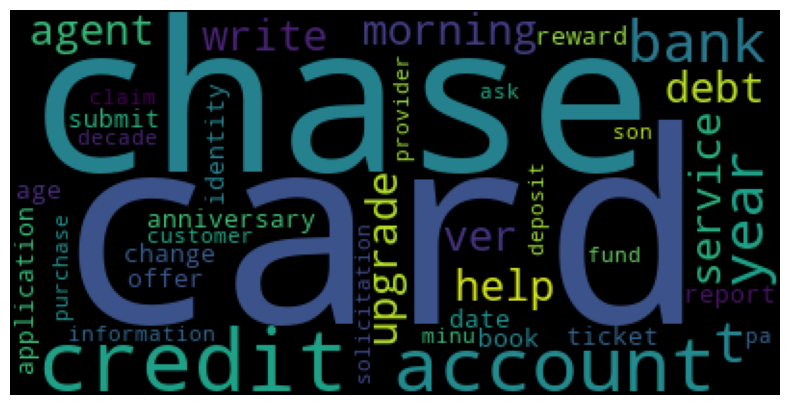

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = nlp.Defaults.stop_words

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [21]:
# funtion for getiing ngram data
def get_ngram(text, ngram=1, top=30):
    cv = CountVectorizer(ngram_range=(ngram, ngram))
    cv.fit(text)
    
    bag_of_words = cv.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_of_words[0, idx]) for word, idx in cv.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [22]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigrams = get_ngram(df_clean.Complaint_clean,ngram=1, top=30)

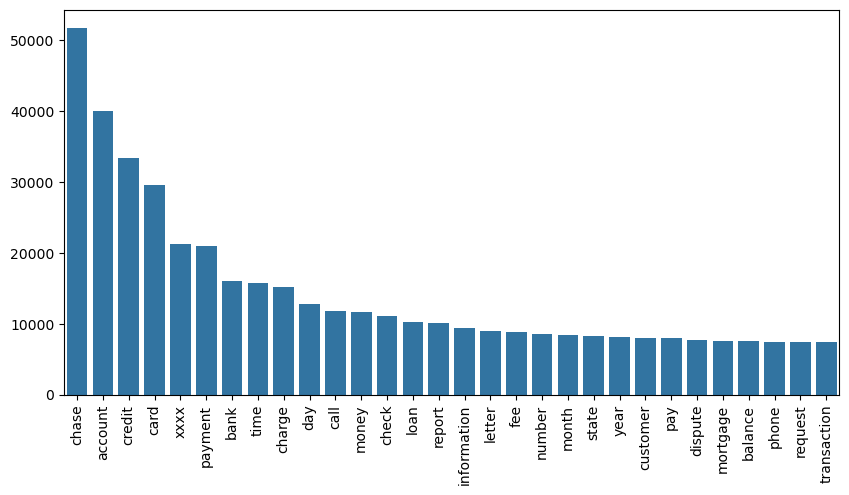

In [23]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(10,5))
sns.barplot(dict(top_30_unigrams[:30]));
plt.xticks(rotation=90);

In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_ngram(df_clean.Complaint_clean,ngram=2, top=30)

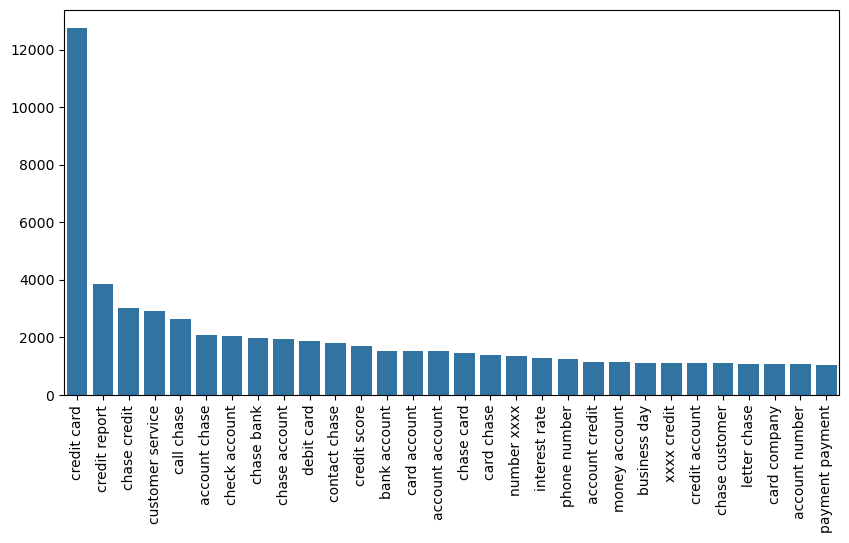

In [25]:
#Print the top 10 words in the bigram frequency
plt.figure(figsize=(10,5))
sns.barplot(dict(top_30_bigrams[:30]));
plt.xticks(rotation=90);

In [26]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_ngram(df_clean.Complaint_clean,ngram=3, top=30)

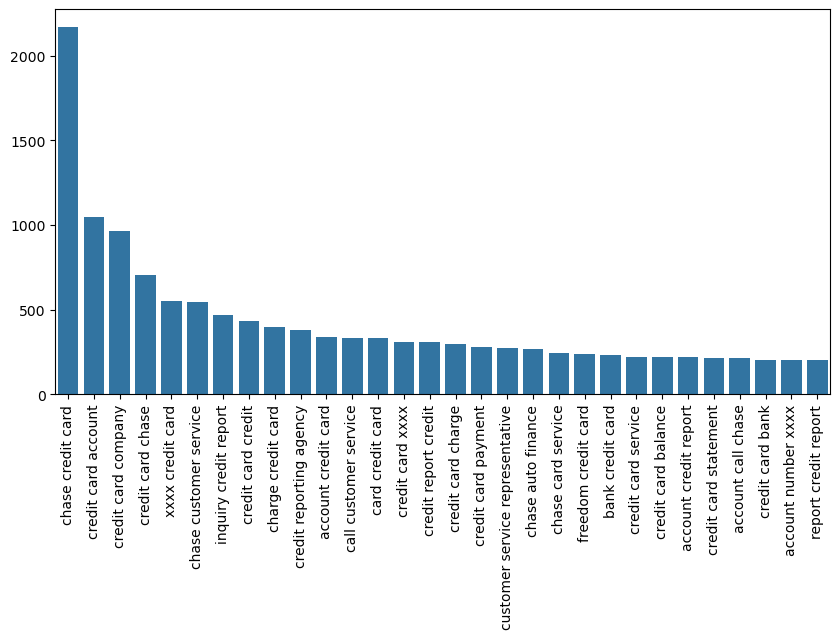

In [27]:
#Print the top 10 words in the trigram frequency
plt.figure(figsize=(10,5))
sns.barplot(dict(top_30_trigrams[:30]));
plt.xticks(rotation=90);

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [28]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [29]:
#All masked texts has been removed
df_clean.head(5)

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...
1,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...
2,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
3,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,book offer ticket reward card information minu...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = tfidf.fit_transform(df_clean.Complaint_clean) 

tfidf.get_feature_names_out()[:10]

array(['18', 'aarp', 'abandonment', 'abatement', 'abd', 'abhorrent',
       'abide', 'ability', 'abovementione', 'abovereference'],
      dtype=object)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [32]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [33]:
nmf_model.fit(document_term_matrix)
len(tfidf.get_feature_names_out())

6424

In [34]:
#Print the Top15 words for each of the topics
num_words=15

W1 = nmf_model.fit_transform(document_term_matrix)
H1 = nmf_model.components_

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
top_15 = [' '.join(t) for t in topic_words]

top_15

['account check money bank deposit chase fund day branch number transfer business transaction customer claim',
 'card credit chase balance account score purchase limit year point month application reason time customer',
 'payment loan mortgage chase month modification time pay year home rate balance property statement date',
 'report credit inquiry information company debt reporting account file identity remove dispute score theft letter',
 'charge dispute fee chase transaction merchant purchase claim refund fraud service time overdraft statement email']

In [35]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.02,0.02,0.01,0
Doc1,0.01,0.01,0.00,0.00,0.00,0
Doc2,0.00,0.03,0.00,0.04,0.00,3
Doc3,0.02,0.03,0.01,0.05,0.01,3
Doc4,0.07,0.00,0.00,0.00,0.00,0


In [36]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = significant_topic #write your code to assign topics to each rows.

In [37]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,0
1,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,0
2,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,3
3,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,book offer ticket reward card information minu...,3
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,0


In [38]:
#Print the first 5 Complaint for each of the Topics
print('----- TOPIC : 0 -----')
print(list(df_clean[df_clean.Topic == 0]['complaint_what_happened'][:5]),'\n')

print('----- TOPIC : 1 -----')
print(list(df_clean[df_clean.Topic == 1]['complaint_what_happened'][:5]), '\n')

print('----- TOPIC : 2 -----')
print(list(df_clean[df_clean.Topic == 2]['complaint_what_happened'][:5]), '\n')

print('----- TOPIC : 3 -----')
print(list(df_clean[df_clean.Topic == 3]['complaint_what_happened'][:5]), '\n')

print('----- TOPIC : 4 -----')
print(list(df_clean[df_clean.Topic == 4]['complaint_what_happened'][:5]), '\n')

----- TOPIC : 0 -----
['good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help', 'i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me', 'my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to spee

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [39]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [40]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,Bank Account services
1,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,Bank Account services
2,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,Theft/Dispute Reporting
3,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,book offer ticket reward card information minu...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,Bank Account services


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Bank Account services'),
  Text(1, 0, 'Theft/Dispute Reporting'),
  Text(2, 0, 'Others'),
  Text(3, 0, 'Mortgage/Loan'),
  Text(4, 0, 'Credit card or prepaid card')])

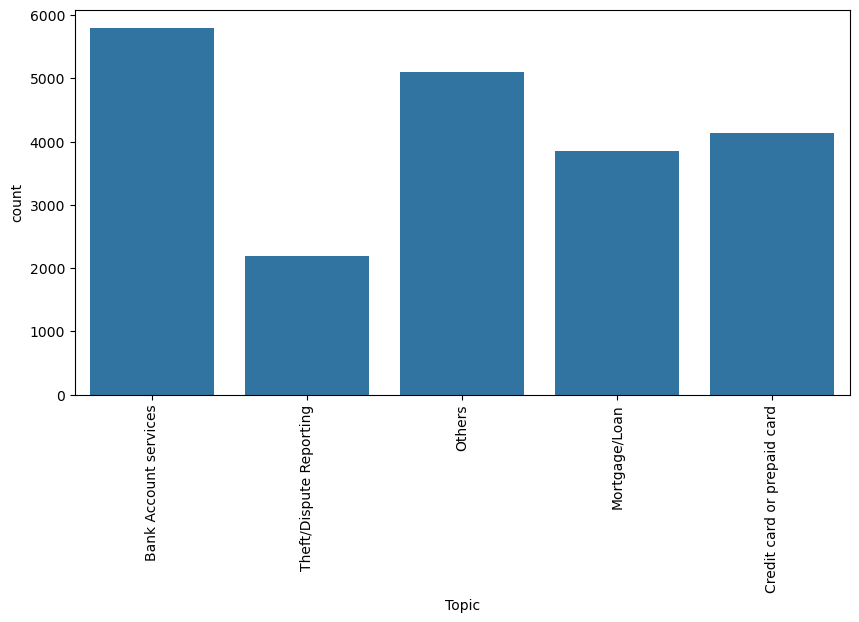

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(x='Topic', data=df_clean)
plt.xticks(rotation=90)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
#Keep the columns "complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [43]:
training_data['complaint_what_happened'][0], training_data['Topic'][0]

('good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help',
 'Bank Account services')

In [44]:
training_data.head()

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,Bank Account services
1,i upgraded my xxxx xxxx card in and was told b...,Bank Account services
2,chase card was reported on however fraudulent ...,Theft/Dispute Reporting
3,on while trying to book a xxxx xxxx ticket i c...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,Bank Account services


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [45]:
#Write your code to get the Vector count
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#Write your code here to transform the word vector to tf-idf
X = vectorizer.fit_transform(training_data.complaint_what_happened)

In [46]:
# Remapping topic names to numbers for supervised learning
topic_mapping = {
    'Bank Account services':0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(topic_mapping)
training_data.head()

y = training_data.Topic

In [47]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [48]:
# Importing required libraries

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [49]:
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [50]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# models
mnb = MultinomialNB() # Multinomial Naive Bayes Classification
log_reg = LogisticRegression() # Logistic Regression
dtc = DecisionTreeClassifier(random_state=40) # Decision Tree Classification
rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True) # Random Forest Classification

# hyperparameter
params = [
    {'alpha': (1, 0.1, 0.01, 0.001, 0.0001)},
    {'C': [0.01, 1, 10],  'penalty': ['l1', 'l2'], 'solver': ['liblinear','newton-cg','saga']},
    {'max_depth': [5,10,20,30], 'min_samples_leaf': [5,10,20,30]},
    {'max_depth': [10,20,30,40], 'min_samples_leaf': [5,10,15,20,30], 'n_estimators': [100,200,500,700]}
]

# Model tuning, fitting and prediction
print('------------ Multinomial Naive Bayes Classification ------------')
# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, params[0], scoring=None)
# fit model
grid_search_mnb.fit(X_train, y_train)
# predict data
y_hat_mnb = grid_search_mnb.predict(X_test)
# print report
print(classification_report(y_test, y_hat_mnb),'\n');

print('--------------------- Logistic Regression ----------------------')
grid_search_log = grid_search(log_reg, folds, params[1], scoring=None)
# fit model
grid_search_log.fit(X_train, y_train)
# predict data
y_hat_log = grid_search_log.predict(X_test)
# print report
print(classification_report(y_test, y_hat_log),'\n');

print('----------------- Decision Tree Classification -----------------')
grid_search_dtc = grid_search(dtc, folds, params[2], scoring='roc_auc_ovr')
# fit model
grid_search_dtc.fit(X_train, y_train)
# predict data
y_hat_dtc = grid_search_dtc.predict(X_test)
# print report
print(classification_report(y_test, y_hat_dtc),'\n');

print('----------------- Random Forest Classification -----------------')
grid_search_rfc = grid_search(rfc, folds, params[3], scoring='roc_auc_ovr')
# fit model
grid_search_rfc.fit(X_train, y_train)
# predict data
y_hat_rfc = grid_search_rfc.predict(X_test)
# print report
print(classification_report(y_test, y_hat_rfc),'\n');

------------ Multinomial Naive Bayes Classification ------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1739
           1       0.71      0.66      0.68      1241
           2       0.81      0.86      0.83      1528
           3       0.80      0.68      0.73       658
           4       0.77      0.71      0.74      1156

    accuracy                           0.77      6322
   macro avg       0.77      0.75      0.76      6322
weighted avg       0.77      0.77      0.77      6322
 

--------------------- Logistic Regression ----------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1739
           1       0.91      0.92      0.92      1241
           2       0.94      0.96      0.95      1528
           3       0.92      0.89      0.

- Logistic Regression seems to be the best model for the given problem with accuracy of 93%

### Testing on a custom text

In [51]:
text = 'i bought a new xxxx xxxx on xxxxxxxx from xxxx xxxx xxxx in xxxx i paid the loan in xxxxxxxxbut chase financial never release the title i contacted chase several time with no \
resolution each time they told me they will release it but nothing was done now i moved to another state and i can not get the registration in the other state because i do not have the title \
i will be obliged to rent a car since i can not use my car'

transformed_text = vectorizer.transform([text])    # transforming the text to tf-idf format

In [52]:
prediction = grid_search_log.predict(transformed_text)     # making prediction on the text
print("The given text belongs to the topic: ", Topic_names[prediction[0]])     # getting output of prediction

The given text belongs to the topic:  Others


In [53]:
text = 'jp morgan chase bank please answer the following questions on xxxxxxxx xxxxxxxxxxxxxxxx xxxxxxxx xxxxxxxx jpmorgan chase accessed information about me through xxxx xxxx xxxx xxxx what was the valid reason for \
accessing my personal information through xxxx xxxx xxxx xxxx the chase checking account that was closed recently during xxxxxxxx had a routing or xxxx number of xxxx according to checks and statements provided to me by chase \
xxxx xxxx xxxx showed chase reporting an xxxx routing number of xxxx before and after i had disputed the xxxx number with chase why do these two routing numbers not match xxxxxxxx i received a response from xxxx xxxx xxxx xxxx to \
a dispute about information chase was providing on my report dispute case id xxxx the information chase had been submitting was deleted due to disputed info being incomplete inaccurate or unverifiable is this true once again i \
have asked questions i will send the cfpb copies of the information i have pertaining to the questions in this complaint via us mail which are the xxxx xxxx xxxx xxxx reports ive received thank you for your attention and humbly \
await your response'

transformed_text = vectorizer.transform([text])    # transforming the text to tf-idf format

prediction = grid_search_log.predict(transformed_text)     # making prediction on the text
print("The given text belongs to the topic: ", Topic_names[prediction[0]])     # getting output of prediction

The given text belongs to the topic:  Mortgage/Loan
